In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from forecasting_utils import *




A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.3 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/sebastianquintero/Library/CloudStorage/OneDrive-QuinteroOrthodontics/MIT/MEng/rag-thesis/.venv/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/sebastianquintero/Library/CloudStorage/OneDrive-QuinteroOrthodontics/MIT/MEng/rag-thesis/.venv/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    ap

In [9]:
df_processed = pd.read_csv('data/processed_FRED_Data.csv')
df_processed.head()
variables = list(df_processed.select_dtypes(include=[np.number]).columns)

### Forecasting Benchmark Implementation:

To conduct the sampling of RMSEs for each variable under each forecast horizion for each model, we will do the following:
- Starting with forecast h=1 and a a 70-30 training-test split, we will iterate over each variable and employ forecasting with horizion h. In other words, starting at quarter i into the time series data, we will forcast the next h quarters. At the time time, we use a univariate AR(1) model to forecast the same next h quarters.

- We will then calculate the RMSE beteween the actual and forecasted values for each variable. We do the same between the AR(1) predicted and actual values. We devide each RSME by the AR(1) RMSE for each respective variable. This is one obvervation.

- We then forecast the next h quarters starting at quarter i+1 into the time series and calculate the RMSE of the forecast for each variable relative to the AR(1), and take its average. This is the second observation. in other words, we have shifted 1 quarter out of the test set and into the training set.

- We repeat this process until 95% of the data is in the training set.

- From these obvervations we will take the mean, std, min, max, q25, q75, and iqr. These are the summary statistics for the models RMSE relative to AR(1) with horizion h.

- We then repeat the process for h=3, h=6, and h=12.

- We then repeat the process for each model.

**For TimeGPT, we will shift the training-test split by 2% of the data each iteration due to API limits

In [10]:
horizons = ["h=1", "h=3", "h=6", "h=12"]
models = ['BVAR', 'ARIMA', 'TimeGPT', 'TimesFM', 'LagLlama', 'Moirai']
variables = list(df_processed.select_dtypes(include=[np.number]).columns)
results = {
    h:{
        model: {
            'RMSE': [],
            'cum_RMSE': {var:[] for var in variables},
        } for model in models
    } for h in horizons

}
results['h=1']['BVAR']

{'RMSE': [],
 'cum_RMSE': {'GDP_log': [],
  'XTIMVA01USM664S_log': [],
  'XTEXVA01USM664S_log': [],
  'GPDI_log': [],
  'RPI_log': [],
  'INDPRO_log': [],
  'BUSLOANS_log': [],
  'NONREVSL_log': [],
  'UNRATE_diff': [],
  'DFF_diff': [],
  'GS1_diff': [],
  'AAA_diff': [],
  'IRLTLT01USM156N_diff': [],
  'M1V': [],
  'CUMFNS': [],
  'CLF16OV': [],
  'B235RC1Q027SBEA': [],
  'ROWFDIQ027S': [],
  'CPILFESL_inflation': [],
  'PCEPI_inflation': []}}

### AR(1) Benchmark

In [11]:
# Example usage:
target_variable = 'GDP_log'
# Try different AR orders
train_data, test_data, _ = test_train_split(df_processed, test_size=0.3)
print(run_ar_benchmark(train_data, test_data, target_variable, ar_order=1, horizon=1))

(np.float64(0.001952543492721004), np.float64(0.24863290323843798))


### Bayesian Vector Autoregression (BVAR)

In [12]:
df_processed = df_processed.select_dtypes(include=[np.number])



for h in [1,3,6,12]:
    print("Forecasting on horizon: " + str(h))
    test_size = 0.3
    train_size = int(len(df_processed)*(1-test_size))
    train_data = df_processed.iloc[:train_size]
    test_data = df_processed.iloc[train_size:]

    current_cum_sums ={var:0 for var in variables}
    while len(test_data) > 13:
        rsmes = []
        for var in variables:
            rmse, _ = fit_evaluate_bvar(train_data, test_data, var, h)
            ar_rmse, _ = run_ar_benchmark(train_data, test_data, var, ar_order=1)
            rsmes.append(rmse/ar_rmse)
            current_cum_sums[var] += rmse
            #print(current_cum_sums[var])  
            results["h="+str(h)]['BVAR']['cum_RMSE'][var].append(current_cum_sums[var])

        results["h="+str(h)]['BVAR']['RMSE'].append(np.mean(rsmes))

        train_size += 1
        train_data = df_processed.iloc[:train_size]
        test_data = df_processed.iloc[train_size:]


Forecasting on horizon: 1
Forecasting on horizon: 3
Forecasting on horizon: 6
Forecasting on horizon: 12


### ARIMA

In [13]:
for h in [1,3,6,12]:
    print("Forecasting on horizon: " + str(h))
    test_size = 0.3
    train_size = int(len(df_processed)*(1-test_size))
    train_data = df_processed.iloc[:train_size]
    test_data = df_processed.iloc[train_size:]

    current_cum_sums ={var:0 for var in variables}
    while len(test_data) > 13:
        rsmes = []
        for var in variables:
            rmse, _ = fit_evaluate_arima(var, train_data, test_data, h)
            ar_rmse, _ = run_ar_benchmark(train_data, test_data, var, ar_order=1)
            rsmes.append(rmse/ar_rmse)
            current_cum_sums[var] += rmse
            #print(current_cum_sums[var])  
            results["h="+str(h)]['ARIMA']['cum_RMSE'][var].append(current_cum_sums[var])

        results["h="+str(h)]['ARIMA']['RMSE'].append(np.mean(rsmes))

        train_size += 1
        train_data = df_processed.iloc[:train_size]
        test_data = df_processed.iloc[train_size:]


Forecasting on horizon: 1
Forecasting on horizon: 3
Forecasting on horizon: 6
Forecasting on horizon: 12


### TimeGPT 

Multiseries Forecast:
https://docs.nixtla.io/docs/capabilities-forecast-multiple_series_forecasting



In [3]:
pip install -Uqq nixtla datasetsforecast utilsforecast

Note: you may need to restart the kernel to use updated packages.


In [4]:
from nixtla import NixtlaClient
from datasetsforecast.long_horizon import LongHorizon
from utilsforecast.losses import mae

nixtla_client = NixtlaClient(
    # defaults to os.environ.get("NIXTLA_API_KEY")
    api_key = 'nixak-Q6bqxtnGbhVX0aqgWPvnwwnAIeyRk4dSJJELRDUBnoYwYnsaUBh1rHTpzhgdX5Bdp9wUCmpyB83SYhIo'
)

'\nMultiseries Forecast:\n'

In [24]:
# Prepare data for TimeGPT by reshaping from wide to long format
def prepare_data_for_timegpt(df):
    # Create a copy to avoid modifying the original
    df = df.copy()
    
    # Rename the date column to 'ds'
    df = df.rename(columns={'observation_date': 'ds'})
    
    # Get list of numeric columns (these will be our variables to forecast)
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    
    # Melt the dataframe to convert from wide to long format
    df_long = pd.melt(
        df,
        id_vars=['ds'],
        value_vars=numeric_columns,
        var_name='unique_id',
        value_name='y'
    )
    
    # Sort by unique_id and date
    df_long = df_long.sort_values(['unique_id', 'ds'])
    
    return df_long

# Apply the transformation
df_timegpt = prepare_data_for_timegpt(df_processed)

# Display the first few rows of the transformed data
print("Shape of transformed data:", df_timegpt.shape)
print("\nFirst few rows of transformed data:")
print(df_timegpt.head())

# Display unique variables being forecast
print("\nUnique variables being forecast:")
print(df_timegpt['unique_id'].unique())

Shape of transformed data: (5160, 3)

First few rows of transformed data:
              ds unique_id         y
2838  1960-04-01  AAA_diff -0.273408
2839  1960-07-01  AAA_diff -0.381349
2840  1960-10-01  AAA_diff  0.023429
2841  1961-01-01  AAA_diff -0.138482
2842  1961-04-01  AAA_diff  0.023429

Unique variables being forecast:
['AAA_diff' 'B235RC1Q027SBEA' 'BUSLOANS_log' 'CLF16OV'
 'CPILFESL_inflation' 'CUMFNS' 'DFF_diff' 'GDP_log' 'GPDI_log' 'GS1_diff'
 'INDPRO_log' 'IRLTLT01USM156N_diff' 'M1V' 'NONREVSL_log'
 'PCEPI_inflation' 'ROWFDIQ027S' 'RPI_log' 'UNRATE_diff'
 'XTEXVA01USM664S_log' 'XTIMVA01USM664S_log']


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: QS-OCT
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: QS-OCT
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: QS-OCT
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: QS-OCT
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint


Detailed RMSE for each variable and horizon:
                           h=1       h=3       h=6      h=12
AAA_diff              0.272894  0.757237  1.138258  0.986416
B235RC1Q027SBEA       0.005867  0.027384  0.027113  0.044816
BUSLOANS_log          0.001587  0.004985  0.010132  0.028655
CLF16OV               0.006262  0.014483  0.020641  0.043631
CPILFESL_inflation    0.248947  0.312809  0.271593  0.213795
CUMFNS                0.213008  0.319672  0.361284  0.527186
DFF_diff              0.154628  0.104243  0.150475  0.861566
GDP_log               0.010782  0.008962  0.007690  0.008245
GPDI_log              0.041507  0.035884  0.031597  0.053894
GS1_diff              0.416252  0.242166  0.369437  1.287004
INDPRO_log            0.015318  0.027999  0.021189  0.031244
IRLTLT01USM156N_diff  0.253626  0.654173  0.818467  0.755995
M1V                   0.031304  0.084470  0.197843  0.381511
NONREVSL_log          0.011493  0.012048  0.013093  0.021212
PCEPI_inflation       0.309412  0.34690

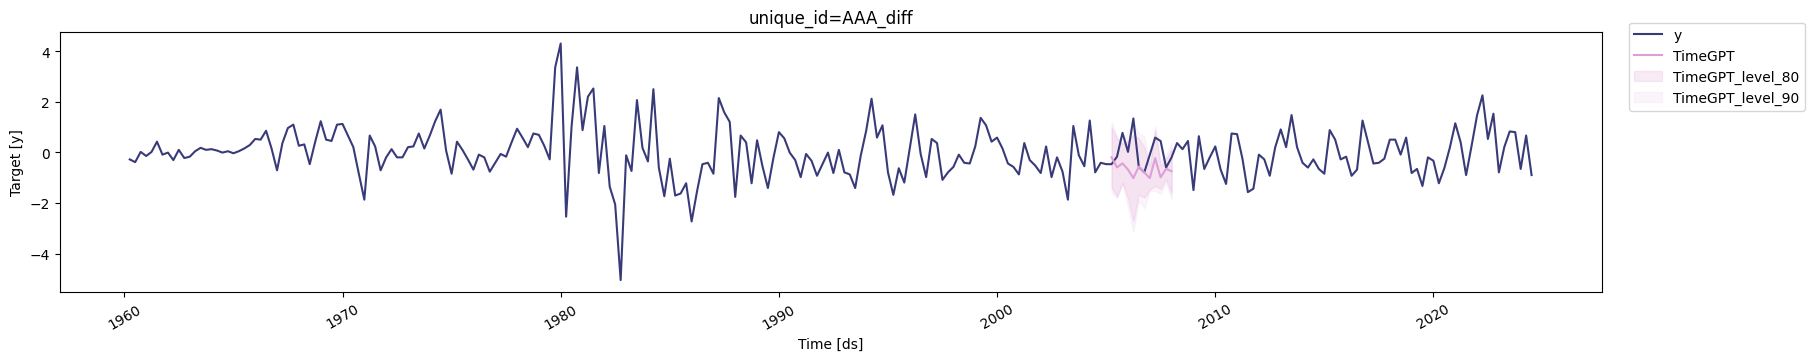

In [25]:
def run_timegpt(df_long, df_transformed, ratio=0.7):
    # Create a copy to avoid modifying the original
    df = df_long.copy()
    
    # Split data into train and test
    split_idx = int(len(df['ds'].unique()) * ratio)
    train_dates = sorted(df['ds'].unique())[:split_idx]
    
    train_data = df[df['ds'].isin(train_dates)]
    test_data = df[~df['ds'].isin(train_dates)]
    
    # Horizons to evaluate
    horizons = [1, 3, 6, 12]
    results = {}
    
    for h in horizons:
        # Generate forecast
        forecast_df = nixtla_client.forecast(
            df=train_data,
            h=h,
            level=[80, 90]
        )
        
        # Calculate RMSE and statistics for each variable
        horizon_results = {}
        rmse_values = []  # Store all RMSE values for this horizon
        
        # Calculate metrics for each unique_id (variable)
        for var in df['unique_id'].unique():
            # Get actual values for this horizon and variable
            var_test = test_data[test_data['unique_id'] == var]['y'].iloc[:h].values
            # Get predictions for this variable
            var_pred = forecast_df[forecast_df['unique_id'] == var]['TimeGPT'].values
            
            # Calculate RMSE
            rmse = np.sqrt(mean_squared_error(var_test, var_pred))
            horizon_results[var] = rmse
            ar1_mse, _ = run_ar_benchmark(df_transformed, var, ar_order=1)
            ratio = rmse/ar1_mse
            rmse_values.append(ratio)
        
        # Calculate statistics for this horizon
        rmse_array = np.array(rmse_values)
        horizon_results['mean_rmse'] = np.mean(rmse_array)
        horizon_results['std_rmse'] = np.std(rmse_array)
        horizon_results['min_rmse'] = np.min(rmse_array)
        horizon_results['max_rmse'] = np.max(rmse_array)
        horizon_results['q25_rmse'] = np.percentile(rmse_array, 25)
        horizon_results['q75_rmse'] = np.percentile(rmse_array, 75)
        horizon_results['iqr_rmse'] = horizon_results['q75_rmse'] - horizon_results['q25_rmse']
            
        results[f'h={h}'] = horizon_results
    
    # Create a DataFrame with the results
    results_df = pd.DataFrame(results)
    
    # Create a summary DataFrame with just the statistics
    stats_cols = ['mean_rmse', 'std_rmse', 'min_rmse', 'max_rmse', 
                  'q25_rmse', 'q75_rmse', 'iqr_rmse']
    stats_df = results_df.loc[stats_cols]
    
    return results_df, stats_df, forecast_df

# Example usage:
results_df, stats_df, last_forecast = run_timegpt(df_timegpt, df_processed)

# Print results
print("\nDetailed RMSE for each variable and horizon:")
print(results_df)
print("\nRMSE Statistics Summary:")
print(stats_df)

# Optional: Plot the last forecast for a specific variable
variable_to_plot = df_timegpt['unique_id'].unique()[0]  # First variable
var_data = df_timegpt[df_timegpt['unique_id'] == variable_to_plot]
var_forecast = last_forecast[last_forecast['unique_id'] == variable_to_plot]

nixtla_client.plot(
    var_data, 
    var_forecast,
    max_insample_length=365, 
    level=[80, 90]
)

In [26]:
print(stats_df)

                h=1       h=3       h=6      h=12
mean_rmse  0.243734  0.296455  0.367336  0.611443
std_rmse   0.216107  0.285313  0.372807  0.610190
min_rmse   0.004719  0.022027  0.021809  0.036049
max_rmse   0.741616  0.946709  1.423067  2.292991
q25_rmse   0.059715  0.052336  0.136529  0.225811
q75_rmse   0.343033  0.404266  0.392273  0.742202
iqr_rmse   0.283317  0.351930  0.255745  0.516391


/var/folders/3b/mhjd36px23sbt4q9lkdqwy_r0000gn/T/ipykernel_36385/985025450.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot([data[h] for h in horizons], labels=horizons)


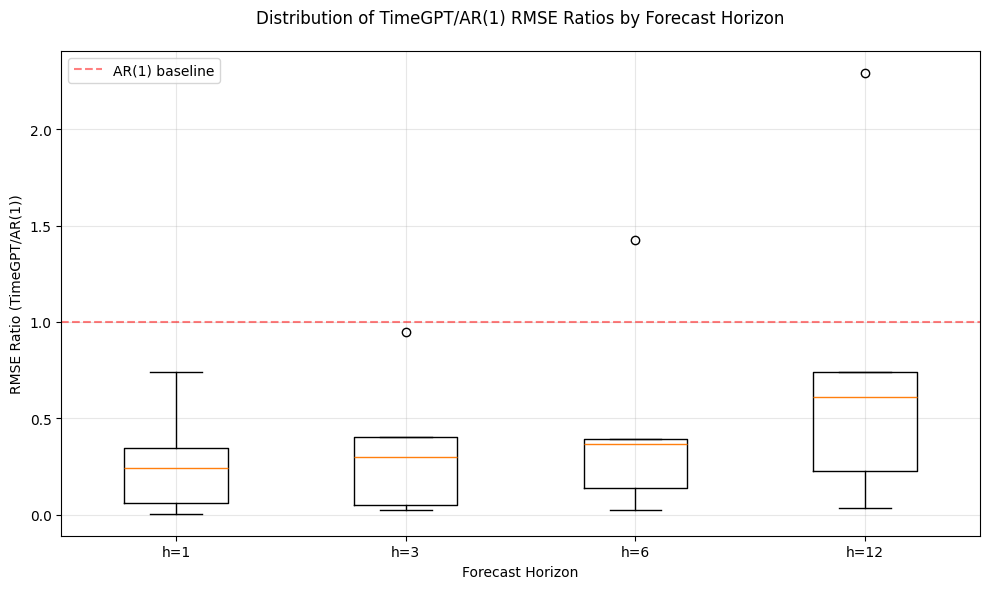

In [27]:
# Create data for boxplot
horizons = ['h=1', 'h=3', 'h=6', 'h=12']
data = {
    'h=1': [0.004719, 0.741616, 0.059715, 0.343033, 0.243734],  # min, max, q25, q75, median(mean)
    'h=3': [0.022027, 0.946709, 0.052336, 0.404266, 0.296455],
    'h=6': [0.021809, 1.423067, 0.136529, 0.392273, 0.367336],
    'h=12': [0.036049, 2.292991, 0.225811, 0.742202, 0.611443]
}

# Create figure and axis
plt.figure(figsize=(10, 6))

# Create boxplot
bp = plt.boxplot([data[h] for h in horizons], labels=horizons)

# Add horizontal line at y=1 to show AR(1) baseline
plt.axhline(y=1, color='r', linestyle='--', alpha=0.5, label='AR(1) baseline')

# Customize plot
plt.title('Distribution of TimeGPT/AR(1) RMSE Ratios by Forecast Horizon', pad=20)
plt.ylabel('RMSE Ratio (TimeGPT/AR(1))')
plt.xlabel('Forecast Horizon')

# Add legend
plt.legend()

# Add grid for better readability
plt.grid(True, alpha=0.3)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

### Plot Distirbution of RMSEs for each model and horizon

### Plot Cumulative RMSEs for each model and variable

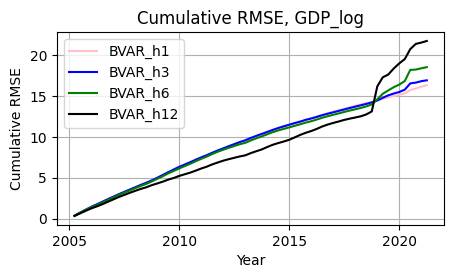

In [120]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates

train_data, test_data, _ = test_train_split(df_processed, test_size=0.3)
# Sample Data
dates = test_data[:-13].index
values = results["h=12"]['BVAR']['cum_RMSE']['GDP_log']  # Replace with your actual data

# Create DataFrame
df = pd.DataFrame({"Date": dates, 
                   "BVAR_h1": results["h=1"]['BVAR']['cum_RMSE']['GDP_log'],
                   "ARIMA_h1": results["h=1"]['ARIMA']['cum_RMSE']['GDP_log'],
                   "BVAR_h3": results["h=3"]['BVAR']['cum_RMSE']['GDP_log'],
                   "ARIMA_h3": results["h=3"]['ARIMA']['cum_RMSE']['GDP_log'],
                   "BVAR_h6": results["h=6"]['BVAR']['cum_RMSE']['GDP_log'],
                   "ARIMA_h6": results["h=6"]['ARIMA']['cum_RMSE']['GDP_log'],
                   "BVAR_h12": results["h=12"]['BVAR']['cum_RMSE']['GDP_log'],
                   "ARIMA_h12": results["h=12"]['ARIMA']['cum_RMSE']['GDP_log']
                   })

# Plot
fig, ax = plt.subplots(figsize=(5, 2.5))
ax.plot(df["Date"], df["BVAR_h1"], color="pink", linestyle="-")
ax.plot(df["Date"], df["BVAR_h3"], color="blue", linestyle="-")
ax.plot(df["Date"], df["BVAR_h6"], color="green", linestyle="-")
ax.plot(df["Date"], df["BVAR_h12"], color="black", linestyle="-")

# Format x-axis
ax.xaxis.set_major_locator(mdates.YearLocator(5))  # Tick every 5 years
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))  # Show only year

# Labels and title
ax.set_xlabel("Year")
ax.set_ylabel("Cumulative RMSE")
ax.set_title("Cumulative RMSE, GDP_log")
ax.legend(["BVAR_h1", "BVAR_h3", "BVAR_h6", "BVAR_h12"])
plt.grid()
plt.show()


65
65
